# Boostrapping Document Classification
Categorizing documents by style is known to be a difficult problem in Machine Learning and Natural Language Processing. However, every bit of success has the potential to reduce the burden of manual labelling.

In this notebook we'll provide a real world example of boostrapping and iterating with document classification.

## The Problem
* The corpus documents of the Latin Library
* Proposed author/era groupings
    * https://en.wikipedia.org/wiki/Classical_Latin
    * https://en.wikipedia.org/wiki/Latin_literature
    * https://en.wikipedia.org/wiki/Latin

## The Goal
* Provide a mapping of authors-to-eras so CLTK users can easily load commonly used slices of corpus data    
    
## Strategy: Supervised Learning
* Label some documents and authors
* Train a classifier and predict the era of unknown docs
* Compare results with human corrections

Often when the task is to classify a large number of documents it is useful to perform several iterations of document classification. Between iterations, one has the opportunity to assess and improve the classifications using semi-supervised learning.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.simplefilter('ignore') # quiet warnings for presentation purposes only

## Imports

In [2]:
import os
import json
from collections import defaultdict
import random
from pathlib import Path
import joblib
from tqdm import tqdm

from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import model_to_dot
from keras.utils import to_categorical
from IPython.display import SVG 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from cltk.corpus.readers import FilteredPlaintextCorpusReader, get_corpus_reader, assemble_corpus
from cltk.corpus.latin.latin_library_corpus_types import corpus_directories_by_type, corpus_texts_by_type
from cltk.prosody.latin.string_utils import punctuation_for_spaces_dict
from cltk.stem.latin.j_v import JVReplacer
from cltk.tokenize.sentence import TokenizeSentence
from cltk.prosody.latin.scansion_constants import ScansionConstants
from cltk.tokenize.word import WordTokenizer
import numpy as np
from sklearn.preprocessing.label import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

Using TensorFlow backend.


### Add parent directory to path so we can access our common code

In [3]:
import sys
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [4]:
from mlyoucanuse.doc2tokens_transformer import Doc2TokensTransformer
from mlyoucanuse.corpus_fun import get_file_type_list 
from mlyoucanuse.text_classification_modeler import TextClassificationModeler
from mlyoucanuse.embeddings import (load_embeddings,
                                    get_embeddings_index,
                                    create_embeddings_matrix,
                                    get_embeddings_layer,
                                    create_embeddings_layer)

### Fix random, for reproducible tests

In [6]:
assert os.environ['PYTHONHASHSEED'] =='0'
import tensorflow as tf

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

### Fast Forward: Our final product has been merged, the works are organized into era categories:

In [7]:
corpus_directories_by_type.keys()

dict_keys(['republican', 'augustan', 'early_silver', 'late_silver', 'old', 'christian', 'medieval', 'renaissance', 'neo_latin', 'misc', 'early'])

In [8]:
corpus_texts_by_type.keys()

dict_keys(['republican', 'augustan', 'early_silver', 'late_silver', 'old', 'early', 'medieval', 'christian', 'renaissance', 'neo_latin', 'misc'])

In [9]:
reader = get_corpus_reader(corpus_name='latin_text_latin_library', language='latin')

for key in corpus_directories_by_type.keys():
    reader = get_corpus_reader(corpus_name='latin_text_latin_library', language='latin')
    reader = assemble_corpus(reader, [key],
                          corpus_directories_by_type, 
                          corpus_texts_by_type )
    print(f'Era: {key} files: {len(reader._fileids)} ')

Era: republican files: 208 
Era: augustan files: 302 
Era: early_silver files: 247 
Era: late_silver files: 118 
Era: old files: 29 
Era: christian files: 347 
Era: medieval files: 12 
Era: renaissance files: 3 
Era: neo_latin files: 75 
Era: misc files: 405 
Era: early files: 1 


## Let's see how we got there:

## Load a CorpusReader

In [10]:
reader = get_corpus_reader(corpus_name='latin_text_latin_library', language='latin')
all_docs = list(reader.fileids())
print(f'{len(all_docs):,} documents in the corpus,  e.g.: {all_docs[:5]}...')
print(f'Random sample: {list(reader.docs(random.sample(all_docs, 1)))[0][200:250]}')

2,141 documents in the corpus,  e.g.: ['12tables.txt', '1644.txt', 'abbofloracensis.txt', 'abelard/dialogus.txt', 'abelard/epistola.txt']...
Random sample: frenare et impetus eius inhibere. Id aliquando pal


## Examine the Data
After gathering counts of file types:
* `find ~/cltk_data/latin/text/latin_text_latin_library/*/ -type d  | wc -l`
* `find ~/cltk_data/latin/text/latin_text_latin_library/*.txt -type f | wc -l`

We find the 2,141 corpus files are organized into 79 directories and 537 files in the top level directory.

So for our first pass of labeling we'll try to label directories which will likely include a large number of files.

## Determine Label Categories
after consulting some Wikipedia articles on the subject: 
* https://en.wikipedia.org/wiki/Classical_Latin 
* https://en.wikipedia.org/wiki/Latin_literature

A popular consensus of organizining by era or time periods is apparent.

We will choose these eras:
* augustan
* christian
* early_silver
* late_silver
* medieval
* neo_latin
* old
* renaissance
* republican

## Label some data, but not all 

We've decided to a dictionary of era category types and a List of file instances:
* era 
    * author directory
   
and

* era
    * file name

e.g.:

In [11]:
manual_corpus_directories_by_type = {
    'republican': [
        './caesar',
        './lucretius',
        './nepos',
        './cicero'
    ],
    'augustan': [
        './livy',
        './ovid',
        './horace',
        './vergil',
        './hyginus'
    ],
    'early_silver': [
        './martial',
        './juvenal',
        './tacitus',
        './lucan',
        './quintilian',
        './sen',
        './statius',
        './silius',
        './columella'
    ],
    'late_silver': [
        './suetonius',
        './gellius',
        './apuleius'
        './justin',
        './apicius',
        './fulgentius',
        './orosius'
    ],
    'old': [
        './plautus'
    ],
    'christian': [
        './ambrose',
        './abelard',
        './alcuin',
        './augustine',
        './bede',
        './bible',
        './cassiodorus',
        './commodianus',
        './gregorytours',
        './hugo',
        './isidore',
        './jerome',
        './prudentius',
        './tertullian',
        './kempis',
        './leothegreat'
    ],
    'medieval': [
        './boethiusdacia',
        './dante'
    ],
    'renaissance': [
    ],
    'neo_latin': [
        './addison',
        './bacon',
        './bultelius',
        './descartes',
        './erasmus',
        './galileo',
        './kepler',
        './may',
        './melanchthon',
        './xylander',
        './campion'
    ]
}

#### by text

manual_corpus_texts_by_type = {
    'republican': [
        'sall.1.txt',
        'sall.2.txt',
        'sall.cotta.txt',
        'sall.ep1.txt',
        'sall.ep2.txt',
        'sall.frag.txt',
        'sall.invectiva.txt',
        'sall.lep.txt',
        'sall.macer.txt',
        'sall.mithr.txt',
        'sall.phil.txt',
        'sall.pomp.txt',
        'varro.frag.txt',
        'varro.ll10.txt',
        'varro.ll5.txt',
        'varro.ll6.txt',
        'varro.ll7.txt',
        'varro.ll8.txt',
        'varro.ll9.txt',
        'varro.rr1.txt',
        'varro.rr2.txt',
        'varro.rr3.txt',
        'sulpicia.txt'
    ],
    'augustan': [
        'resgestae.txt',
        'resgestae1.txt',
        'manilius1.txt',
        'manilius2.txt',
        'manilius3.txt',
        'manilius4.txt',
        'manilius5.txt',
        'catullus.txt',
        'vitruvius1.txt',
        'vitruvius10.txt',
        'vitruvius2.txt',
        'vitruvius3.txt',
        'vitruvius4.txt',
        'vitruvius5.txt',
        'vitruvius6.txt',
        'vitruvius7.txt',
        'vitruvius8.txt',
        'vitruvius9.txt',
        'propertius1.txt',
        'tibullus1.txt',
        'tibullus2.txt',
        'tibullus3.txt'
    ],
    'early_silver': [
        'pliny.ep1.txt',
        'pliny.ep10.txt',
        'pliny.ep2.txt',
        'pliny.ep3.txt',
        'pliny.ep4.txt',
        'pliny.ep5.txt',
        'pliny.ep6.txt',
        'pliny.ep7.txt',
        'pliny.ep8.txt',
        'pliny.ep9.txt',
        'pliny.nh1.txt',
        'pliny.nh2.txt',
        'pliny.nh3.txt',
        'pliny.nh4.txt',
        'pliny.nh5.txt',
        'pliny.nhpr.txt',
        'pliny.panegyricus.txt',
        'petronius1.txt',
        'petroniusfrag.txt',
        'persius.txt',
        'phaedr1.txt',
        'phaedr2.txt',
        'phaedr3.txt',
        'phaedr4.txt',
        'phaedr5.txt',
        'phaedrapp.txt',
        'seneca.contr1.txt',
        'seneca.contr10.txt',
        'seneca.contr2.txt',
        'seneca.contr3.txt',
        'seneca.contr4.txt',
        'seneca.contr5.txt',
        'seneca.contr6.txt',
        'seneca.contr7.txt',
        'seneca.contr8.txt',
        'seneca.contr9.txt',
        'seneca.fragmenta.txt',
        'seneca.suasoriae.txt',
        'valeriusflaccus1.txt',
        'valeriusflaccus2.txt',
        'valeriusflaccus3.txt',
        'valeriusflaccus4.txt',
        'valeriusflaccus5.txt',
        'valeriusflaccus6.txt',
        'valeriusflaccus7.txt',
        'valeriusflaccus8.txt',
        'valmax1.txt',
        'valmax2.txt',
        'valmax3.txt',
        'valmax4.txt',
        'valmax5.txt',
        'valmax6.txt',
        'valmax7.txt',
        'valmax8.txt',
        'valmax9.txt',
        'vell1.txt',
        'vell2.txt'
    ],
    'late_silver': [
    ],
    'old': [
        '12tables.txt',
        'ter.adel.txt',
        'ter.andria.txt',
        'ter.eunuchus.txt',
        'ter.heauton.txt',
        'ter.hecyra.txt',
        'ter.phormio.txt',
        'andronicus.txt',
        'enn.txt'
    ],
    'medieval': [
        'anselmepistula.txt',
        'anselmproslogion.txt',
        'carm.bur.txt'
    ],
    'christian': [
        'anon.martyrio.txt',
        'benedict.txt',
        'berengar.txt',
        'bernardclairvaux.txt',
        'bernardcluny.txt',
        'bonaventura.itinerarium.txt',
        'creeds.txt',
        'decretum.txt',
        'diesirae.txt',
        'egeria.txt',
        'ennodius.txt',
        'eucherius.txt',
        'eugippius.txt',
        'greg.txt',
        'gregory.txt',
        'gregory7.txt',
        'hydatius.txt',
        'hymni.txt',
        'innocent.txt',
        'hydatius.txt',
        'junillus.txt',
        'lactantius.txt',
        'liberpontificalis.txt',
        'macarius.txt',
        'macarius1.txt',
        'novatian.txt',
        'papal.txt',
        'paulinus.poemata.txt',
        'perp.txt',
        'professio.txt',
        'prosperus.txt',
        'regula.txt',
        'sedulius.txt',
        'sulpiciusseverus.txt',
        'vorag.txt'
    ],
    'renaissance': [
        'petrarch.ep1.txt',
        'petrarch.numa.txt',
        'petrarch.rom.txt'
    ],
    'neo_latin': [
        'spinoza.ethica1.txt',
        'spinoza.ethica2.txt',
        'spinoza.ethica3.txt',
        'spinoza.ethica4.txt',
        'spinoza.ethica5.txt'
    ]
}


## find sparse categories and considering dropping

In [12]:
for key in manual_corpus_texts_by_type:
    print(key, len(manual_corpus_texts_by_type[key]))

for key in manual_corpus_directories_by_type:
    print(key, len(manual_corpus_directories_by_type[key]))

republican 23
augustan 22
early_silver 57
late_silver 0
old 9
medieval 3
christian 35
renaissance 3
neo_latin 5
republican 4
augustan 5
early_silver 9
late_silver 6
old 1
christian 16
medieval 2
renaissance 0
neo_latin 11


### We could remove some of the classes with not much representation for greater accuracy


#### The following were directories that weren't obviously divisible into periods based on the web site/file directory layout.
 
	./alanus',
	'./albertanus',
	'./albertofaix',
	'./aquinas',
	'./ammianus',
	'./arnobius',
	'./capellanus',
	'./cato',
	'./claudian',
	'./curtius',
	'./eutropius',
	'./frontinus',
	'./gestafrancorum',
	'./justinian',
	'./lactantius',
	'./martinbraga',
	'./mirandola',
	'./ottofreising',
	'./pauldeacon',
	'./sha',
	'./theodosius',
	'./voragine',
	'./walter',
	'./williamtyre',
 

## Assemble a CorpusReader of our classified docs

In [14]:
reader = assemble_corpus(reader, manual_corpus_texts_by_type.keys(),
                         manual_corpus_directories_by_type, 
                         manual_corpus_texts_by_type )
files_types = get_file_type_list(reader.fileids(), manual_corpus_texts_by_type, manual_corpus_directories_by_type)
docs_already_classified, categories = zip(*files_types)
reader._fileids = docs_already_classified
docs_to_classify = list(set(all_docs) ^ set(docs_already_classified))
print(f'Docs already classified: {len(docs_already_classified):,}')
print(f'Docs to classify: {len(docs_to_classify):,}')

Docs already classified: 1,278
Docs to classify: 863


## Create a LabelEncoder to convert the label names to integers, later on we'll reverse the process

In [15]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform( np.array(categories).ravel())
print(f'Y shape: {y.shape} e.g.: {y}')
print(f'Label encoder classes: {label_encoder.classes_}')

Y shape: (1278,) e.g.: [6 1 1 ... 0 0 5]
Label encoder classes: ['augustan' 'christian' 'early_silver' 'late_silver' 'medieval'
 'neo_latin' 'old' 'renaissance' 'republican']


In [16]:
# you can use integer labels if your loss method is: sparse_categorical_crossentropy
# otherwise you need to one-hot encode for categorical_crossentropy
y = to_categorical(y)
y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Build the word index from the tokenizer

In [17]:
tokenizer = Tokenizer()
for doc in reader.docs():
    tokenizer.fit_on_texts([doc])
print(f'Vocabulary size: {len(tokenizer.word_index):,}')

Vocabulary size: 335,847


In [18]:
text_sequences = tokenizer.texts_to_sequences(reader.docs() )
maxlen = 500
X = pad_sequences(text_sequences, maxlen=maxlen) 
print(f'doc matrix size: {len(X):,}')

doc matrix size: 1,278


### Create our train, validation and test sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
# With a larger labelled data set our test size would be higher, but lower here is okay
# because we just want to see some differences among classifiers
print(f'X_train size: {len(X_train):,}, X_test size: {len(X_test):,} X_validate: {len(X_validate)}')
print(f'y_train size: {len(y_train):,}, y_test size: {len(y_test):,}')

X_train size: 1,022, X_test size: 128 X_validate: 128
y_train size: 1,022, y_test size: 128


### Load the custom word embeddings and initialize an Embeddings layer with the word index mappings

In [20]:
vector_file ='latin_library.2019.06.01.kv'
the_embeddings_file = str(Path(parentdir) / 'quality_embeddings' / vector_file)

embedding_layer = create_embeddings_layer(the_embeddings_file, 
                                          embeddings_dimensions=50, 
                                          max_len=maxlen,
                                          layer_name=vector_file, 
                                          int_word_map=tokenizer.index_word,
                                          trainable=True)

### Build the model, specifying the max sequence length that will be input and the number of expected class outputs

In [21]:
modeler = TextClassificationModeler(max_sequence_len=maxlen, outputs=len(label_encoder.classes_))
model = modeler.build_model(embedding_layer)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 500)          0                                            
__________________________________________________________________________________________________
latin_library.2019.06.01.kv (Em (None, 500, 50)      16792400    main_input[0][0]                 
__________________________________________________________________________________________________
Conv_static_2 (Conv1D)          (None, 499, 100)     10100       latin_library.2019.06.01.kv[0][0]
__________________________________________________________________________________________________
Conv_static_3 (Conv1D

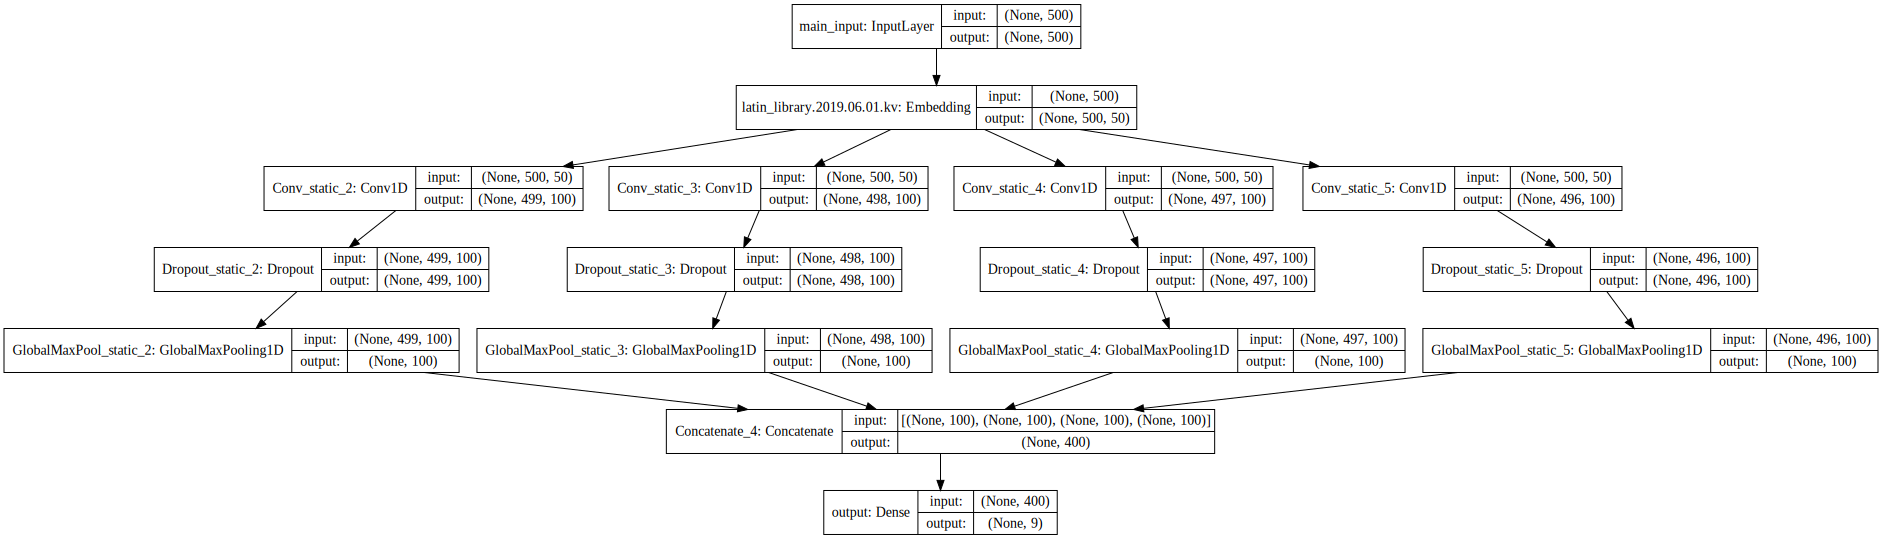

In [22]:
SVG(model_to_dot(model,
                 show_layer_names=True,
                 show_shapes=True).create(prog='dot',
                                          format='svg'))

In [23]:
history = model.fit(X_train, y_train,
                               validation_data=(X_validate, y_validate),
                               epochs=10,
                               batch_size=16)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1022 samples, validate on 128 samples
Epoch 1/10
1022/1022 [==============================] - 41s 40ms/step - loss: 0.3013 - acc: 0.8883 - val_loss: 0.2907 - val_acc: 0.8889
Epoch 2/10
1022/1022 [==============================] - 33s 32ms/step - loss: 0.2540 - acc: 0.8993 - val_loss: 0.2682 - val_acc: 0.9019
Epoch 3/10
1022/1022 [==============================] - 28s 28ms/step - loss: 0.2113 - acc: 0.9131 - val_loss: 0.2375 - val_acc: 0.9019
Epoch 4/10
1022/1022 [==============================] - 32s 31ms/step - loss: 0.1531 - acc: 0.9490 - val_loss: 0.1861 - val_acc: 0.9349
Epoch 5/10
1022/1022 [==============================] - 31s 30ms/step - loss: 0.0963 - acc: 0.9720 - val_loss: 0.1435 - val_acc: 0.9427
Epoch 6/10
1022/1022 [==============================] - 30s 30ms/step - loss: 0.0625 - acc: 0.9826 - val_loss: 0.1069 - val_acc: 0.9635
Epoch 7/10


In [24]:
scores = model.evaluate(X_validate, y_validate, verbose=0)
print(f'Validation Accuracy: {scores[1]*100:.2f}')
scores = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {scores[1]*100:.2f}')

Validation Accuracy: 98.44
Test Accuracy: 98.44


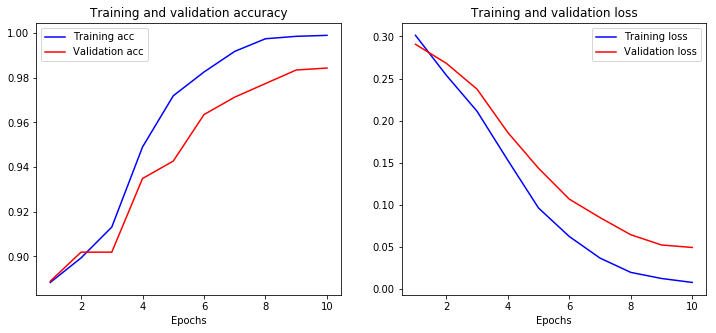

In [25]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(12, 5))
    ax = fig.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.legend() 

plot_history(history)

In [26]:
# build on all the data
model.fit(X, y, epochs=10, batch_size=16, verbose=0)

### Save the full model for later reuse

In [27]:
model.save('latin_lib_text_classifier.h5')
# Save the weights
model.save_weights('latin_lib_text_classifier.weights.h5')
# Save the model architecture
with open('latin_lib_text_classifier.json', 'wt') as f:
    f.write(model.to_json())

## Train a Dummy classifier to see the baseline we must improve above

In [28]:
dummy = DummyClassifier(strategy='stratified', random_state=0)
features_train, features_test, target_train, target_test = train_test_split(X, y, random_state=0)
dummy.fit(features_train, target_train)
dummy_score = dummy.score(features_test, target_test)
print(f'Dummy classifier: {dummy_score}')

Dummy classifier: 0.09375


In [29]:
unclassified_reader = get_corpus_reader(corpus_name='latin_text_latin_library', language='latin')
unclassified_reader.skip_keywords = None
to_classify_X = list(unclassified_reader.docs(docs_to_classify))

to_classifiy_text_sequences = tokenizer.texts_to_sequences(to_classify_X) 
X_to_classify = pad_sequences(to_classifiy_text_sequences, maxlen=maxlen) 

new_labels = model.predict(X_to_classify)
print (f'Shape new_labels: {new_labels.shape} e.g.: {new_labels[:5]}...')

Shape new_labels: (863, 9) e.g.: [[0.00432568 0.92420524 0.006294   0.00718294 0.03493618 0.00673939
  0.00534755 0.00724847 0.00372057]
 [0.04817082 0.53210557 0.05511622 0.03467779 0.14223675 0.11070037
  0.02675422 0.03172681 0.01851147]
 [0.01800546 0.66584754 0.02058923 0.0509186  0.11318957 0.07362895
  0.01064849 0.03456243 0.01260981]
 [0.32194114 0.03925986 0.1507133  0.06123512 0.08807521 0.06859252
  0.15273228 0.01547298 0.10197753]
 [0.04135046 0.54780877 0.03906925 0.07485621 0.16423507 0.03899204
  0.03813888 0.03021078 0.02533854]]...


### Find the labels with the highest probability

In [30]:
new_label_ints = [np.argmax(tmp) for tmp in new_labels]

new_cats = defaultdict(list)
for idx, filename in enumerate(docs_to_classify):
    new_cats[label_encoder.classes_[new_label_ints[idx]]].append(filename)

with open('new_cats.json', mode='w', encoding='utf8') as writer:
    json.dump(new_cats, writer, indent=2)

predicted_files_cats = [ (item, key ) 
               for key, value in new_cats.items()
              for item in value               ]
predicted_files_cats.sort(key=lambda x: x[0])
print(f'Number of predicted file categories: {len(predicted_files_cats)}')
print('Random sample of predictions:\n', "\n".join([str(tmp) for tmp in random.sample(predicted_files_cats, 10)]))

Number of predicted file categories: 863
Random sample of predictions:
 ('theodosius/theod06.txt', 'augustan')
('albertanus/albertanus.sermo1.txt', 'christian')
('williamtyre/20.txt', 'christian')
('williamtyre/5.txt', 'christian')
('walter7.txt', 'neo_latin')
('gaius2.txt', 'late_silver')
('justin/15.txt', 'neo_latin')
('buchanan.txt', 'early_silver')
('exivi.txt', 'christian')
('pascoli.catull.txt', 'republican')


### Coarse grain classifications can provide important signals:
* possible changes in authorship
* out-of-character stylistic variations

E.g. look at the predictions for Sidonius: 
* ('sidonius1.txt', 'late_silver'),
* ('sidonius2.txt', 'late_silver'),
* ('sidonius3.txt', 'late_silver'),
* ('sidonius4.txt', 'late_silver'),
* ('sidonius5.txt', 'late_silver'),
* ('sidonius6.txt', 'late_silver'),
* ('sidonius7.txt', 'christian'),
* ('sidonius8.txt', 'late_silver'),
* ('sidonius9.txt', 'christian'),
    
Although he was a Fifth century writer out of Gaul, he appears to have significant similarities to late Silver era prose. In a strict historical sense he would belong to the Christian era for classification, but his prose clearly contains some silver elements. 
This mixing of eras is common, as many later writers have tried to follow the prose style of Caesar or Cicero, republic era writers.

In [31]:
predicted_files_cats

[('1644.txt', 'christian'),
 ('abbofloracensis.txt', 'christian'),
 ('adso.txt', 'christian'),
 ('aelredus.txt', 'christian'),
 ('agnes.txt', 'christian'),
 ('alanus/alanus1.txt', 'early_silver'),
 ('alanus/alanus2.txt', 'neo_latin'),
 ('albertanus/albertanus.arsloquendi.txt', 'christian'),
 ('albertanus/albertanus.liberconsol.txt', 'christian'),
 ('albertanus/albertanus.sermo.txt', 'christian'),
 ('albertanus/albertanus.sermo1.txt', 'christian'),
 ('albertanus/albertanus.sermo2.txt', 'christian'),
 ('albertanus/albertanus.sermo3.txt', 'christian'),
 ('albertanus/albertanus.sermo4.txt', 'christian'),
 ('albertanus/albertanus1.txt', 'christian'),
 ('albertanus/albertanus2.txt', 'augustan'),
 ('albertanus/albertanus3.txt', 'christian'),
 ('albertanus/albertanus4.txt', 'christian'),
 ('albertofaix/hist1.txt', 'christian'),
 ('albertofaix/hist10.txt', 'christian'),
 ('albertofaix/hist11.txt', 'christian'),
 ('albertofaix/hist12.txt', 'christian'),
 ('albertofaix/hist2.txt', 'christian'),
 